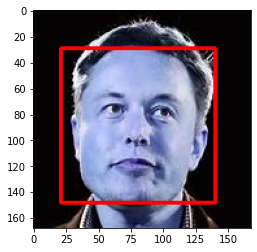

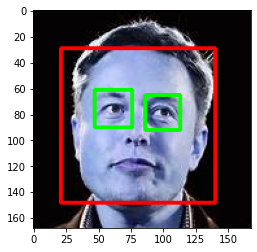

elon_musk
Generating cropped images in folder:  ./model/dataset/cropped/elon_musk
jack_ma
Generating cropped images in folder:  ./model/dataset/cropped/jack_ma
jeff_bezos
Generating cropped images in folder:  ./model/dataset/cropped/jeff_bezos
marissa_mayer
Generating cropped images in folder:  ./model/dataset/cropped/marissa_mayer
mark_zuckerberg
Generating cropped images in folder:  ./model/dataset/cropped/mark_zuckerberg


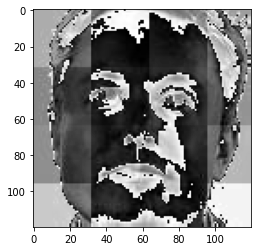

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 10 10:56:24 2022

@author: ShivamSharma
"""

import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt


# reading a test image 

img=cv2.imread(r'.\model\test_images/elon1.jpg')
img.shape
#(550,700,3)
# 3 represents rgb value

plt.imshow(img)
# convert rgb image into grayscale image

gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape
plt.imshow(gray,cmap='gray')


# https://docs.opencv.org/3.4/d2/d99/tutorial_js_face_detection.html

# above site has readymade API to detect face and eyes so i am just gonna use that

# face detection using haar cascade
# haar cascade uses moving window to detect face and eyes

face_cascade = cv2.CascadeClassifier('./model/opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./model/opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces
# [x,y,width,height]


(x,y,w,h)=faces[0]
face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

# detect eyes

cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()


# plot reason of interest i.e face
plt.imshow(roi_color, cmap='gray')


# create function which takes image as input and return roi as output
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color


# original image
original_image = cv2.imread('./model/test_images/elon1.jpg')
plt.imshow(original_image)

# check the function by passing original image

cropped_image = get_cropped_image_if_2_eyes('./model/test_images/elon1.jpg')
plt.imshow(cropped_image)

# check function for obstructed image
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./model/test_images/elon2.jpg')
cropped_image_no_2_eyes

path_to_data = "./model/dataset/"
path_to_cr_data = "./model/dataset/cropped/"


import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        

img_dirs

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)



cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1  





# Now we will use wavelet tranform to extract important facial features of face Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now


def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')


class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict
    

X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  
        
    

    




In [3]:
img_dirs

['./model/dataset/elon_musk',
 './model/dataset/jack_ma',
 './model/dataset/jeff_bezos',
 './model/dataset/marissa_mayer',
 './model/dataset/mark_zuckerberg']

In [4]:
len(X)

285

In [5]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(285, 4096)

In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10,probability=True))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.75

In [8]:
class_dict

{'elon_musk': 0,
 'jack_ma': 1,
 'jeff_bezos': 2,
 'marissa_mayer': 3,
 'mark_zuckerberg': 4}

In [9]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [10]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [11]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.826024,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.587265,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.868106,{'logisticregression__C': 1}


In [13]:
best_estimators['svm'].score(X_test,y_test)

0.7638888888888888

In [17]:
best_clf = best_estimators['svm']

In [18]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [19]:
#Save class dictionary
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))